## EX_07 인물사진을 만들어보자

#### lubric 
1. 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
2. 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시: 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

#### trial and error

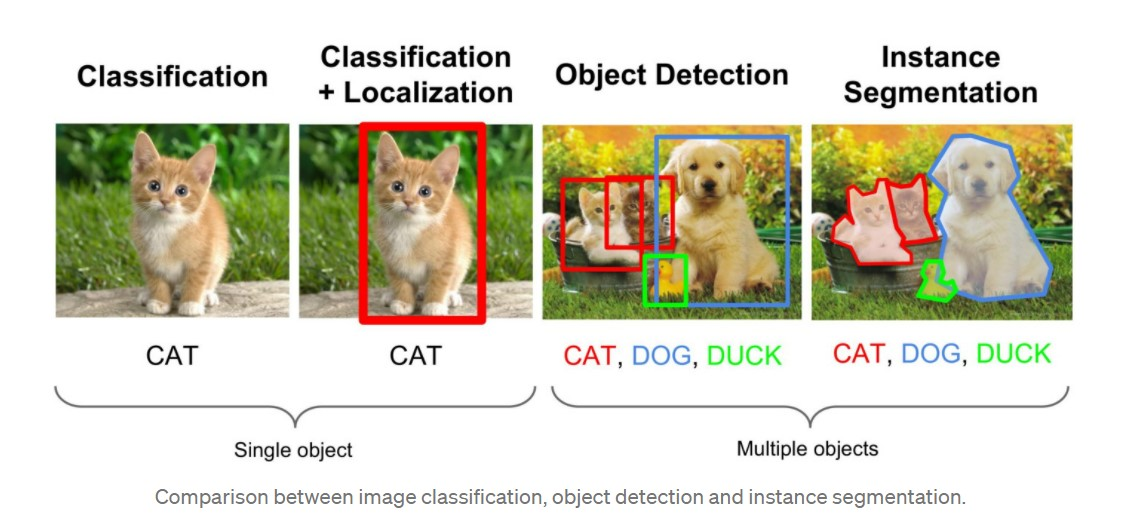

In [1]:
from IPython.display import Image

Image("DETECTION.jpg")

In [2]:
import os
import urllib  # urllib는 웹에서 데이터를 다운로드할 때 사용
import cv2     # cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np 
from pixellib.semantic import semantic_segmentation # pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

print('슝=3')

슝=3


### selfie

(1440, 1440, 3)


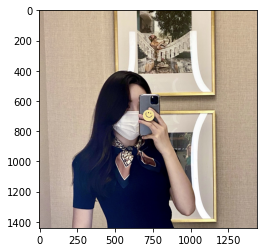

In [3]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_07/human_segmentation/images/src.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용된다. 오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 이용. DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있다.

In [4]:
# PixelLib에서 제공해 주는 모델을 다운로드

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_07/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/EXPLORATIONS/EX_07/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f9901a7ff10>)

In [5]:
# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [6]:
#  모델에 이미지를 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

In [7]:
# PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다

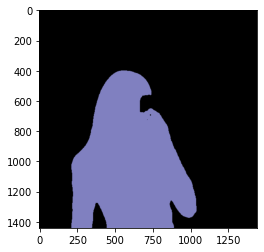

In [8]:
plt.imshow(output) # output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요
plt.show()

In [9]:
segvalues  # segvalues에는 class_ids와 masks가 있습니다.

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
for class_id in segvalues['class_ids']:  #class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요! 
    print(LABEL_NAMES[class_id])

background
person


이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [11]:
# 주목해야 할 것은 생상 코드 결과물
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
colormap[15] #사람을 나타내는 15번째 색상

array([192, 128, 128])

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

In [13]:
seg_color = (128,128,192)

(1440, 1440)


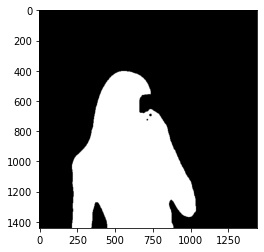

In [14]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었습니다.

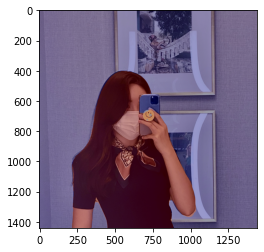

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

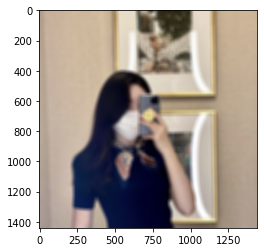

In [16]:
# 이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (30,30))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

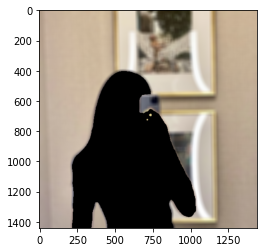

In [17]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)   # bitwise_not 연산은 이미지가 반전, 하고 나면 배경은 255, 사람은 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 
# 결국 사람이 사라지게 되는 거죠.

이제 배경 영상과 사람 영상을 합치기

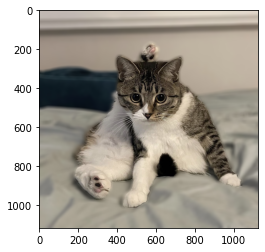

In [45]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다.
# np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용

### ⭐문제점⭐

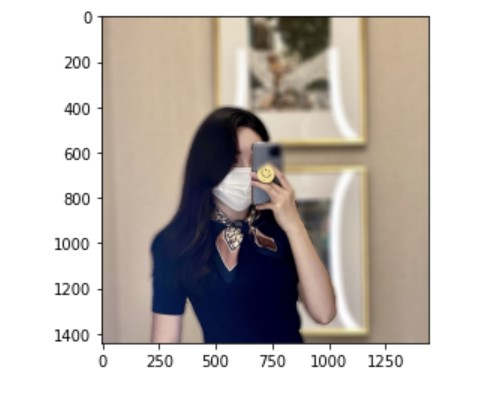

In [19]:
from IPython.display import Image

Image("human_segmentation/images/result2.jpg")

보이다시피 인물사진에 카메라 윗부분이 빠져있음을 알 수 있다. 인물이 아니라 배경으로 취급되는 것. 확인을위해 다시 보자

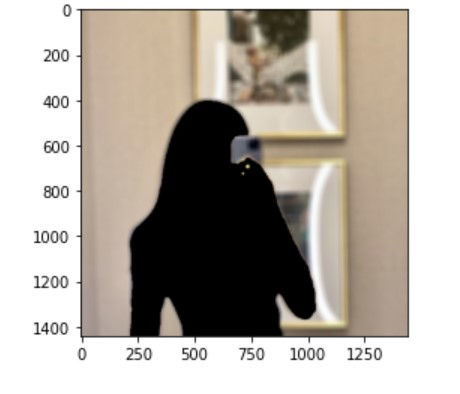

In [20]:
Image("human_segmentation/images/result.jpg")

역시나 배경에 카메라가 포함이 되어있다. 

### cat

(1119, 1125, 3)


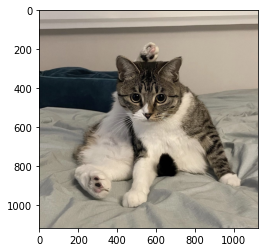

In [21]:
img_path2 = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_07/human_segmentation/images/src2.jpg'  
img_orig = cv2.imread(img_path2) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
# PixelLib에서 제공해 주는 모델을 다운로드

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_07/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/EXPLORATIONS/EX_07/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f97ebaff160>)

In [23]:
# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [24]:
#  모델에 이미지를 입력

segvalues, output = model.segmentAsPascalvoc(img_path2)

In [25]:
# PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

우리는 이 중 고양이(cat) 라벨, 즉 8를 가진 영역만 검출해 내고 싶습니다

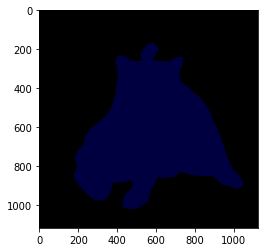

In [26]:
plt.imshow(output) # output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요
plt.show()

In [27]:
segvalues  # segvalues에는 class_ids와 masks가 있습니다.

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [28]:
for class_id in segvalues['class_ids']:  #class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요! 
    print(LABEL_NAMES[class_id])

background
cat


In [29]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [30]:
colormap[8] #고양이를 나타내는 8번째 색상

array([64,  0,  0])

In [31]:
seg_color = (0,0,64)

(1119, 1125)


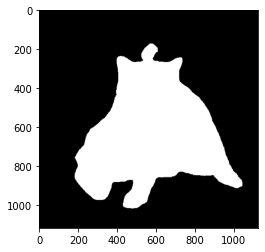

In [32]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

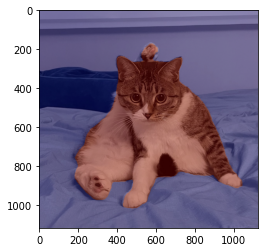

In [33]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

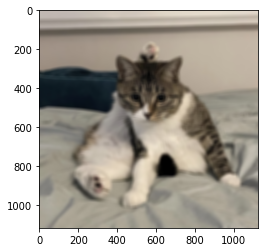

In [34]:
# 이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

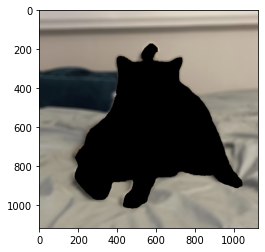

In [35]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)   # bitwise_not 연산은 이미지가 반전, 하고 나면 배경은 255, 사람은 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 
# 결국 사람이 사라지게 되는 거죠.

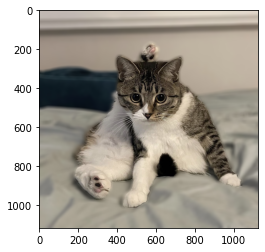

In [36]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다.
# np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했네요.

### chroma key

(1080, 1440, 3)


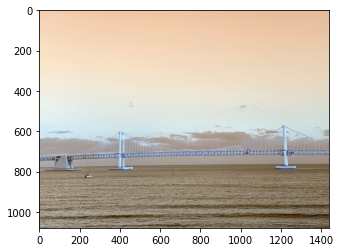

In [40]:
#배경사진 불러와서 크기 확인
img_path4 = os.getenv('HOME')+ '/aiffel/EXPLORATIONS/EX_07/human_segmentation/images/광안리.jpg' # 사진이 저장된 경로 
img_sea = cv2.imread(img_path4) 
print(img_sea.shape)

plt.imshow(img_sea)
plt.show()

(1119, 1125, 3)


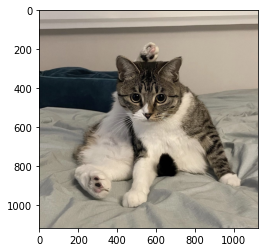

In [41]:
# 고양이 사진 불러와서 크기 확인

img_path_cat = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_07/human_segmentation/images/src2.jpg'  
cat_orig = cv2.imread(img_path_cat) 
print (cat_orig.shape)

plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.show()

(1080, 1085, 3)


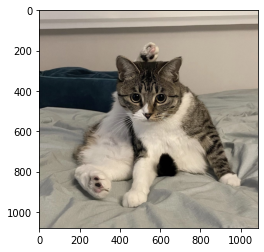

In [42]:
# 배경 이미지와 세로 길이 맞춰주기

ratio = cat_orig.shape[1]/cat_orig.shape[0]
height = img_sea.shape[0]
width = int(height*ratio)

cat_orig = cv2.resize(cat_orig, (width, height), interpolation=cv2.INTER_AREA)
print (cat_orig.shape)

plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.show()

(1080, 1440, 3) (1080, 1440, 3)


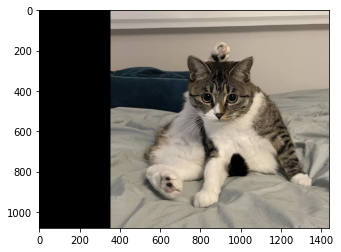

In [43]:
# 배경과 크기를 맞춰주기 위해 왼쪽 공간을 검은색으로 채움

pad = img_sea.shape[1] - cat_orig.shape[1]

cat_padding = cv2.copyMakeBorder(cat_orig,
                                  top = 0,
                                  bottom = 0,
                                  left = pad,
                                  right = 0,
                                  borderType = cv2.BORDER_CONSTANT,
                                  value=[0,0,0])

print (img_sea.shape, cat_padding.shape)
plt.imshow(cv2.cvtColor(cat_padding, cv2.COLOR_BGR2RGB))
plt.show()

In [48]:
img_concat = np.where(img_mask_color==255, cat_padding, img_sea)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: operands could not be broadcast together with shapes (1119,1125,3) (1080,1440,3) (1080,1440,3) 

<Figure size 129600x51840 with 0 Axes>

#### trial and error

순서대로 착착 하다가 사진 크기까지 맞췄는데 1119,1125,3이란 숫자가 왜 어디서 나온건지 모르겠어서 막혔다
인물사진 문제점도 찾아냈지만 크로마키 사진을 제대로 못해서 속상한 마음이지만 다음 과제를 더 열심히 해보는 걸로 :))
역시 CV는 잘되다가 안될 때가 재밌는데 고로 이번과제는 여기서 끝인걸로...ㅎㅎㅎ